This notebook merges the 6 2011 NAIP Utah data into a mosaic and computes the NDVI of the mosaic. It also crops the mosaic to the site boundary and saves that to a tif file.
The notebook started as an exploration of each file individually by plotting each separately and then determining bounds of the images and then plotting them all together. 

In [1]:
# Import packages and set working directory if needed here
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
from rasterio.merge import merge
from rasterio.plot import show # may not keep this import, checking the what the mosaic looks like (https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html)
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.clip as cl
from shapely.geometry import mapping, box
from shapely.geometry import Polygon

# set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

## Open the 6 Scenes that cover the site

In [2]:
# Open NAIP datasets
# Top Left Scene
naip_top_left_filepath = "data/final-project/cottonwood-heights-utah/naip/20110810/m_4011127_nw_12_1_20110806.tif"
with rio.open(naip_top_left_filepath) as naip_tl_src:
    naip_2011_tl_scene = naip_tl_src.read()
    naip_2011_tl_scene_meta = naip_tl_src.meta
    naip_2011_tl_scene_bds = naip_tl_src.bounds

# Top Middle Scene
naip_top_middle_filepath = "data/final-project/cottonwood-heights-utah/naip/20110810/m_4011127_ne_12_1_20110806.tif"
with rio.open(naip_top_middle_filepath) as naip_tm_src:
    naip_2011_tm_scene = naip_tm_src.read()
    naip_2011_tm_scene_meta = naip_tm_src.meta
    naip_2011_tm_scene_bds = naip_tm_src.bounds

# Top Right Scene
naip_top_right_filepath = "data/final-project/cottonwood-heights-utah/naip/20110810/m_4011128_nw_12_1_20110810.tif"
with rio.open(naip_top_right_filepath) as naip_tr_src:
    naip_2011_tr_scene = naip_tr_src.read()
    naip_2011_tr_scene_meta = naip_tr_src.meta
    naip_2011_tr_scene_bds = naip_tr_src.bounds

# Bottom Left Scene
naip_bottom_left_filepath = "data/final-project/cottonwood-heights-utah/naip/20110810/m_4011127_sw_12_1_20110806.tif"
with rio.open(naip_bottom_left_filepath) as naip_bl_src:
    naip_2011_bl_scene = naip_bl_src.read()
    naip_2011_bl_scene_meta = naip_bl_src.meta
    naip_2011_bl_scene_bds = naip_bl_src.bounds

# Bottom Middle Scene
naip_bottom_middle_filepath = "data/final-project/cottonwood-heights-utah/naip/20110810/m_4011127_se_12_1_20110806.tif"
with rio.open(naip_bottom_middle_filepath) as naip_bm_src:
    naip_2011_bm_scene = naip_bm_src.read()
    naip_2011_bm_scene_meta = naip_bm_src.meta
    naip_2011_bm_scene_bds = naip_bm_src.bounds

# Bottom Right Scene
naip_bottom_right_filepath = "data/final-project/cottonwood-heights-utah/naip/20110810/m_4011128_sw_12_1_20110810.tif"
with rio.open(naip_bottom_right_filepath) as naip_br_src:
    naip_2011_br_scene = naip_br_src.read()
    naip_2011_br_scene_meta = naip_br_src.meta
    naip_2011_br_scene_bds = naip_br_src.bounds

In [3]:
naip_br_src.crs

CRS({'init': 'epsg:26912'})

## Plot the 6 scenes separately

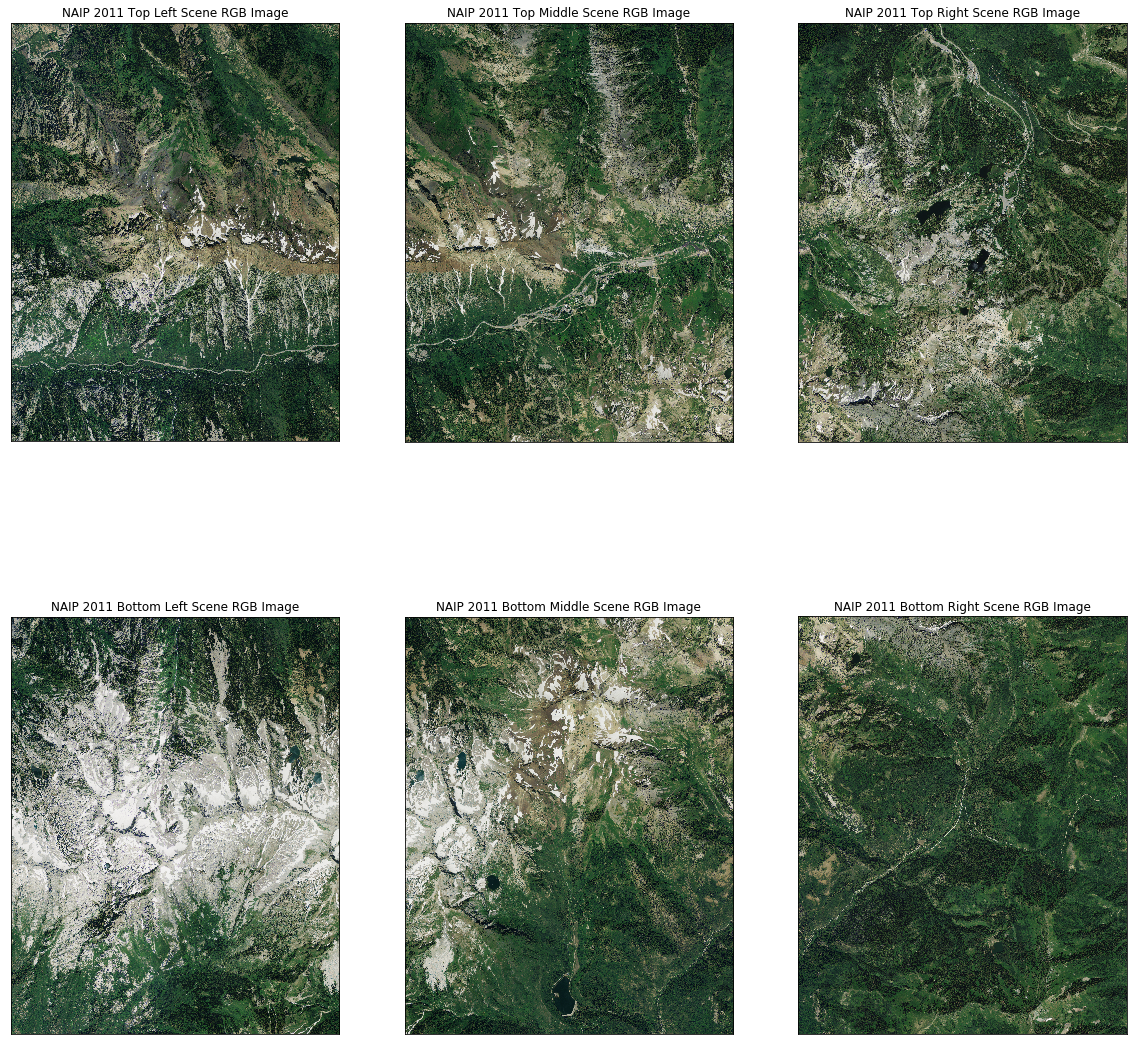

In [3]:
# Plot the data
# Plot each scene separately but in the correct order
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,  figsize=(20, 20))

# Plot the top left RGB
es.plot_rgb(naip_2011_tl_scene,
            rgb=[0, 1, 2],
            # extent=plotting_extent(naip2015),
            ax=ax1)
ax1.set_title('NAIP 2011 Top Left Scene RGB Image', fontsize=12)

# Plot the top middle RGB
es.plot_rgb(naip_2011_tm_scene,
            rgb=[0, 1, 2],
            # extent=plotting_extent(naip2015),
            ax=ax2)
ax2.set_title('NAIP 2011 Top Middle Scene RGB Image', fontsize=12)

# Plot the top right RGB
es.plot_rgb(naip_2011_tr_scene,
            rgb=[0, 1, 2],
            # extent=plotting_extent(naip2015),
            ax=ax3)
ax3.set_title('NAIP 2011 Top Right Scene RGB Image', fontsize=12)

# Plot the bottom left RGB
es.plot_rgb(naip_2011_bl_scene,
            rgb=[0, 1, 2],
            # extent=plotting_extent(naip2015),
            ax=ax4)
ax4.set_title('NAIP 2011 Bottom Left Scene RGB Image', fontsize=12)

# Plot the bottom middle RGB
es.plot_rgb(naip_2011_bm_scene,
            rgb=[0, 1, 2],
            # extent=plotting_extent(naip2015),
            ax=ax5)
ax5.set_title('NAIP 2011 Bottom Middle Scene RGB Image', fontsize=12)

# Plot the bottom right RGB
es.plot_rgb(naip_2011_br_scene,
            rgb=[0, 1, 2],
            # extent=plotting_extent(naip2015),
            ax=ax6)
ax6.set_title('NAIP 2011 Bottom Right Scene RGB Image', fontsize=12)

plt.show()

### Look at the bounds of each scene and manually create a bounding box

In [4]:
naip_2011_tl_scene_bds

BoundingBox(left=436190.0, bottom=4490100.0, right=442170.0, top=4497720.0)

In [5]:
naip_2011_tr_scene_bds

BoundingBox(left=446780.0, bottom=4490030.0, right=452740.0, top=4497630.0)

In [6]:
naip_2011_bl_scene_bds

BoundingBox(left=436130.0, bottom=4483170.0, right=442110.0, top=4490780.0)

In [7]:
naip_2011_br_scene_bds

BoundingBox(left=446730.0, bottom=4483090.0, right=452700.0, top=4490690.0)

In [8]:
naip_2011_tm_scene_bds

BoundingBox(left=441480.0, bottom=4490060.0, right=447450.0, top=4497670.0)

In [9]:
naip_2011_bm_scene_bds

BoundingBox(left=441430.0, bottom=4483130.0, right=447410.0, top=4490730.0)

In [10]:
# left, right, bottom, top
extent_all = (436130.0, 452740.0, 4483090.0, 4497720.0)
extent_all[0]

436130.0

In [11]:
# left, right, bottom, top
#extent_tl = (436190.0, 442170.0, 4490100.0, 4497720.0)
#extent_tm = (441480.0, 447450.0, 4490060.0, 4497670.0)
#extent_tr = (446780.0, 452740.0, 4490030.0, 4497630.0)
#extent_bl = (436130.0, 442110.0, 4483170.0, 4490780.0)

## Programatically create the bounding box of all 6 scenes

In [12]:
# left, right, bottom, top
extent_tl = (naip_2011_tl_scene_bds[0], naip_2011_tl_scene_bds[2], naip_2011_tl_scene_bds[1], naip_2011_tl_scene_bds[3])
extent_tm = (naip_2011_tm_scene_bds[0], naip_2011_tm_scene_bds[2], naip_2011_tm_scene_bds[1], naip_2011_tm_scene_bds[3])
extent_tr = (naip_2011_tr_scene_bds[0], naip_2011_tr_scene_bds[2], naip_2011_tr_scene_bds[1], naip_2011_tr_scene_bds[3])
extent_bl = (naip_2011_bl_scene_bds[0], naip_2011_bl_scene_bds[2], naip_2011_bl_scene_bds[1], naip_2011_bl_scene_bds[3])
extent_bm = (naip_2011_bm_scene_bds[0], naip_2011_bm_scene_bds[2], naip_2011_bm_scene_bds[1], naip_2011_bm_scene_bds[3])
extent_br = (naip_2011_br_scene_bds[0], naip_2011_br_scene_bds[2], naip_2011_br_scene_bds[1], naip_2011_br_scene_bds[3])

In [13]:
# Open boundary shapefile
clip_out_path = "data/final-project/cottonwood-heights-utah/vector-clip/utah-avalanche-clip.shp"
avalanche_boundary = gpd.read_file(clip_out_path)

## Plot all 6 scenes in one plot with the site boundary on top

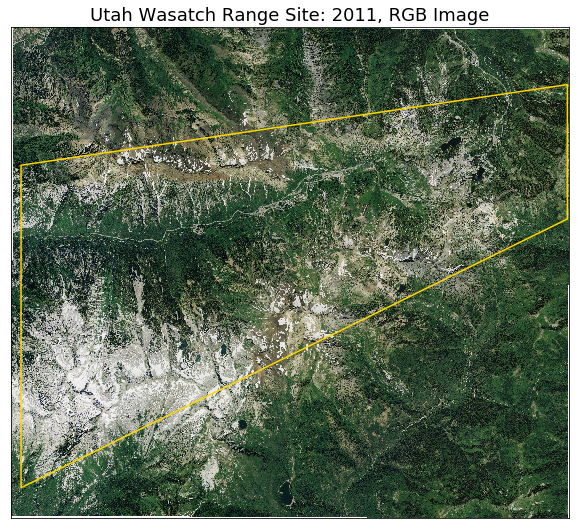

In [14]:
# Plot the data
# Plot all 6 scenes in one
fig, ax1 = plt.subplots(figsize=(10, 10))

# Plot band 1 only
#tl = ax1.imshow(naip_2011_tl_scene[0], extent=extent_tl)
#tm = ax1.imshow(naip_2011_tm_scene[0], extent=extent_tm)
#tr = ax1.imshow(naip_2011_tr_scene[0], extent=extent_tr)
#bl = ax1.imshow(naip_2011_bl_scene[0], extent=extent_bl)
#bm = ax1.imshow(naip_2011_bm_scene[0], extent=extent_bm)
#br = ax1.imshow(naip_2011_br_scene[0], extent=extent_br)
# Plot the top left RGB
#es.plot_rgb(naip_2011_tl_scene,
#            rgb=[0, 1, 2],
#            extent=extent_tl,
#            ax=ax1)


# Plot the top left RGB
es.plot_rgb(naip_2011_tl_scene,
            rgb=[0, 1, 2],
            extent=extent_tl,
            ax=ax1)

# Plot the top middle RGB
es.plot_rgb(naip_2011_tm_scene,
            rgb=[0, 1, 2],
            extent=extent_tm,
            ax=ax1)

# Plot the top right RGB
es.plot_rgb(naip_2011_tr_scene,
            rgb=[0, 1, 2],
            extent=extent_tr,
            ax=ax1)

# Plot the bottom left RGB
es.plot_rgb(naip_2011_bl_scene,
            rgb=[0, 1, 2],
            extent=extent_bl,
            ax=ax1)

# Plot the bottom middle RGB
es.plot_rgb(naip_2011_bm_scene,
            rgb=[0, 1, 2],
            extent=extent_bm,
            ax=ax1)

# Plot the bottom right RGB
es.plot_rgb(naip_2011_br_scene,
            rgb=[0, 1, 2],
            extent=extent_br,
            ax=ax1)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="gold")

# Set title and full plot boundaries
ax1.set_title('Utah Wasatch Range Site: 2011, RGB Image', fontsize=18)
ax1.set_xbound(lower=extent_all[0], upper=extent_all[1])
ax1.set_ybound(lower=extent_all[2], upper=extent_all[3])

# Save image to file
fig.savefig('data/final-project/utah-site.png')
plt.show()

## Compute the NDVI for One Scene and Plot

In [15]:
type(naip_2011_tl_scene[0,0,0])

numpy.uint8

In [16]:
# Convert the data to int to avoid the divide by zero error
naip_2011_tl_scene = naip_2011_tl_scene.astype(int)
# Compute NDVI
ndvi_tl = es.normalized_diff(b2=naip_2011_tl_scene[3], b1=naip_2011_tl_scene[2])

In [17]:
# Plot the NDVI
#fig, ax1 = plt.subplots(figsize=(10, 10))
#tl = ax1.imshow(ndvi_tl, extent=extent_tl)

## Merge all scenes together into one array

In [33]:
# Create output file name path
out_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2011_mosaic.tif"

# If the output file doesn't already exist, create it
if os.path.exists(out_fp) == False:
    
    # Create list of files to merge
    src_data_dir = "data/final-project/cottonwood-heights-utah/naip/20110810/"
    search_criteria = "m*.tif"
    file_list = glob(os.path.join(src_data_dir, search_criteria))

    # Open each file in rasterio
    # Create an empty list that will hold all the opened files
    src_files_to_mosaic = []

    # Loop through and open each file and add it to the mosaic list
    for file in file_list:
        src = rio.open(file)
        src_files_to_mosaic.append(src)

    # Using rasterio.merge, merge all files into one array
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Write the mosaic to an output file
    # Set up the metadata for the output file
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans,
                     "crs": src.crs})

    with rio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

In [19]:
# Do a quick plot of the mosaic
#show(mosaic)

## Open and Plot the Mosaic

In [20]:
with rio.open(out_fp) as mosaic_2011_src:
    mosaic_2011_scene = mosaic_2011_src.read()
    mosaic_2011_scene_meta = mosaic_2011_src.meta
    mosaic_2011_scene_bds = mosaic_2011_src.bounds

In [21]:
type(mosaic_2011_scene_bds)

rasterio.coords.BoundingBox

In [22]:
type(extent_bm)

tuple

In [23]:
mosaic_extent = plotting_extent(mosaic_2011_src)
mosaic_extent

(436130.0, 452740.0, 4483090.0, 4497720.0)

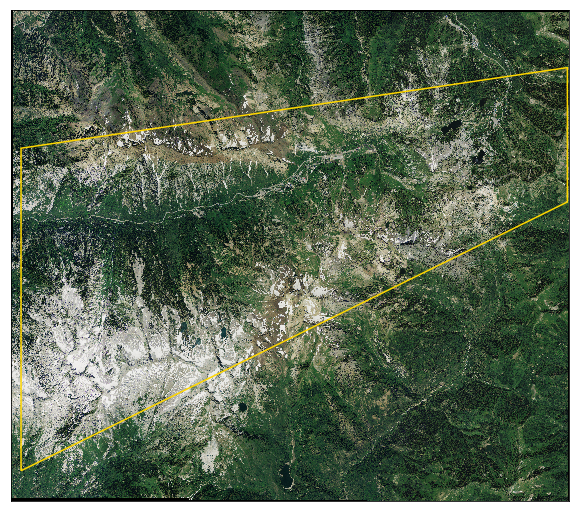

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot RGB of the mosaic
es.plot_rgb(mosaic_2011_scene,
            rgb=[0, 1, 2],
            extent=plotting_extent(mosaic_2011_src),
            ax=ax1)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="gold")

plt.show()

In [25]:
# Open avalanche paths
avalanche_paths_filename = glob(os.path.join(
    'data', 'final-project', 'cottonwood-heights-utah', 'avalanche-paths', '*.shp'))
avalanche_paths = gpd.read_file(avalanche_paths_filename[0])

# Clip data to boundary
avalanche_clip = cl.clip_shp(avalanche_paths, avalanche_boundary)

In [26]:
avalanche_boundary

poly_no                                           geometry
0        1  POLYGON ((436438 4484000, 436438 4493600, 4527...

## Compute NDVI of the Mosaic

In [27]:
# Convert the data to int to avoid the divide by zero error
mosaic_2011_scene = mosaic_2011_scene.astype(int)
# Compute NDVI
ndvi_mosaic = es.normalized_diff(b2=mosaic_2011_scene[3], b1=mosaic_2011_scene[2])

C:\Users\windnage\Anaconda3\envs\earth-analytics-python\lib\site-packages\earthpy\spatial.py:75: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b2 - b1) / (b2 + b1)


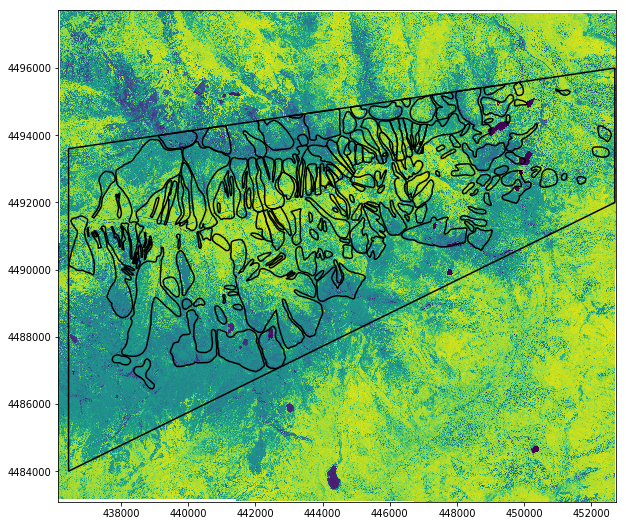

In [28]:
# Plot the NDVI mosaic
fig, ax1 = plt.subplots(figsize=(10, 10))
mos = ax1.imshow(ndvi_mosaic, extent=mosaic_extent)
# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="black")
avalanche_clip.boundary.plot(ax=ax1, color="black")
plt.show()

## Clip the mosaic to the site boundary

In [29]:
with rio.open(out_fp) as mosaic_2011_src:
    mosaic_2011_crop, mosaic_2011_meta = es.crop_image(
        mosaic_2011_src, avalanche_boundary)
    mosaic_2011_extent = plotting_extent(
        mosaic_2011_crop[0], mosaic_2011_meta['transform'])

In [32]:
mosaic_2011_crop.shape

(4, 12000, 16262)

## Plot the RGB of the cropped mosaic

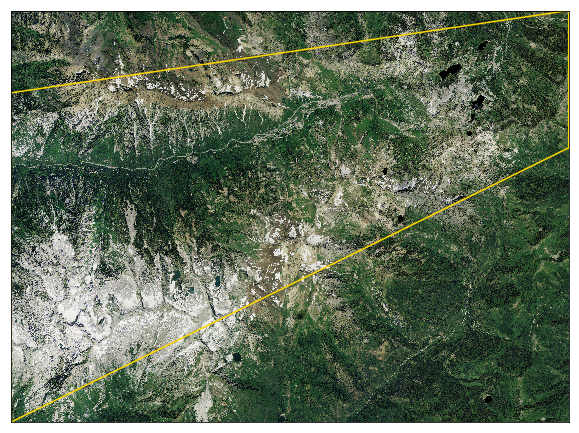

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot RGB of the cropped mosaic
es.plot_rgb(mosaic_2011_crop,
            rgb=[0, 1, 2],
            extent=mosaic_2011_extent,
            ax=ax1)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="gold")

plt.show()

In [34]:
out_trans

Affine(1.0, 0.0, 436130.0,
       0.0, -1.0, 4497720.0)

In [37]:
mosaic_2011_meta['transform']

Affine(1.0, 0.0, 436438.0,
       0.0, -1.0, 4496000.0)

In [36]:
mosaic_2011_src.crs

CRS({'init': 'epsg:26912'})

## Write cropped mosaic to tif file and plot it to verify it looks correct

In [38]:
# Write the cropped mosaic to an output file if it doesn't already exist
# Set up file name to output to
crop_2011_fn = 'data/final-project/cottonwood-heights-utah/naip/outputs/naip_2011_mosaic_crop.tif'

if os.path.exists(crop_2011_fn) == False:
    
    # Set up the metadata for the output file
    out_meta_crop = mosaic_2011_src.meta.copy()
    out_meta_crop.update({"driver": "GTiff",
                     "height": mosaic_2011_crop.shape[1],
                     "width": mosaic_2011_crop.shape[2],
                     "transform": mosaic_2011_meta['transform'],
                     "crs": mosaic_2011_src.crs})

    with rio.open(crop_2011_fn, "w", **out_meta_crop) as dest:
        dest.write(mosaic_2011_crop)

In [39]:
# Open cropped mosaic to make sure the writing of the file worked
with rio.open(crop_2011_fn) as mosaic_2011_crop_src:
    mosaic_2011_crop_scene = mosaic_2011_crop_src.read()
    mosaic_2011_crop_scene_meta = mosaic_2011_crop_src.meta
    mosaic_2011_crop_scene_bds = mosaic_2011_crop_src.bounds

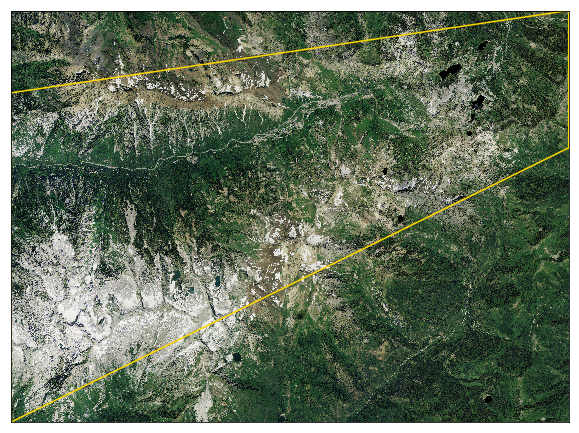

In [40]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot RGB of the mosaic
es.plot_rgb(mosaic_2011_crop_scene,
            rgb=[0, 1, 2],
            extent=plotting_extent(mosaic_2011_crop_src),
            ax=ax1)

# Plot site boundary
avalanche_boundary.boundary.plot(ax=ax1, color="gold")

plt.show()